<a href="https://colab.research.google.com/github/fatimasood/XAI-Diabetes-Prediction/blob/main/XAI_(LIME%2BSHAP)_using_stacking_ensemble_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XAI for Prediction of Diabetes using Stacking Classifier


**Dataset:** diabetes.csv (expects a column `Outcome` as target)  
**Goal:** build a robust, balanced stacking classifier pipeline with:
- KNN imputation
- Robust scaling
- Per-class OneClassSVM outlier filtering
- SMOTE+ENN balancing
- Tune base learners (KNN, SVM, XGBoost)
- Build stacking ensemble (regularized meta-learner)
- CV, hold-out test evaluation
- Learning curve
- XAI: SHAP (global + beeswarm) and LIME (per-sample)
- Save models and visualizations to `visualizations/`

---

**Notes**
- Edit `DATA_PATH` if needed.
- This notebook avoids verbose prints; each section shows only the important outputs.
- All figures are saved into `visualizations/`.


# 📦 INSTALLATIONS & IMPORTS

In [150]:
# Install required packages (uncomment if running in a fresh environment)

!pip install -q imbalanced-learn xgboost lime shap optuna joblib


In [151]:
# %%time
# ===========================
# Imports & Setup
# ===========================
import os
import warnings
import time
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn import tree
import seaborn as sns
sns.set(style="whitegrid")

from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
from sklearn.svm import OneClassSVM, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split, learning_curve
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
                             classification_report, confusion_matrix, roc_curve, precision_recall_curve, auc, average_precision_score)

import shap
import lime
import lime.lime_tabular
import joblib

warnings.filterwarnings("ignore")
RND = 42
np.random.seed(RND)

# Output directory
OUTDIR = Path("visualizations")
OUTDIR.mkdir(parents=True, exist_ok=True)


# 📥 DATA LOADING & INITIAL EXPLORATION

**Load the dataset**

In [152]:
#Data Loading
DATA_PATH = "/content/diabetes2.csv"

TEST_SIZE = 0.20
CV_FOLDS = 5
N_JOBS = -1


**Display basic information**

In [153]:
df = pd.read_csv(DATA_PATH)
assert 'Outcome' in df.columns, "Dataset must contain 'Outcome' target column."

print(f"Raw shape: {df.shape}")
display(df.head(5))

# Quick class distribution
class_dist = df['Outcome'].value_counts().to_dict()
print("Class counts:", class_dist)


Raw shape: (2000, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


Class counts: {0: 1316, 1: 684}


**Analyse the data**

In [154]:
# Preprocessing helpers

# Columns where 0 is not a valid value (medical measurements)
medical_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
medical_cols = [c for c in medical_cols if c in df.columns]

# Replace zeros with NaN in those columns
df[medical_cols] = df[medical_cols].replace(0, np.nan)

# Features and target
X = df.drop(columns=['Outcome'])
y = df['Outcome'].copy()


## **DATA PREPROCESSING**

**KNN IMPUTATION FOR MISSING DATA**

In [155]:
# KNN IMPUTATION

imputer = KNNImputer(n_neighbors=7, weights='distance')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
joblib.dump(imputer, OUTDIR / "imputer_knn.joblib")

missing_after = X_imputed.isnull().sum().sum()
print(f"Missing after imputation: {missing_after}")


Missing after imputation: 0


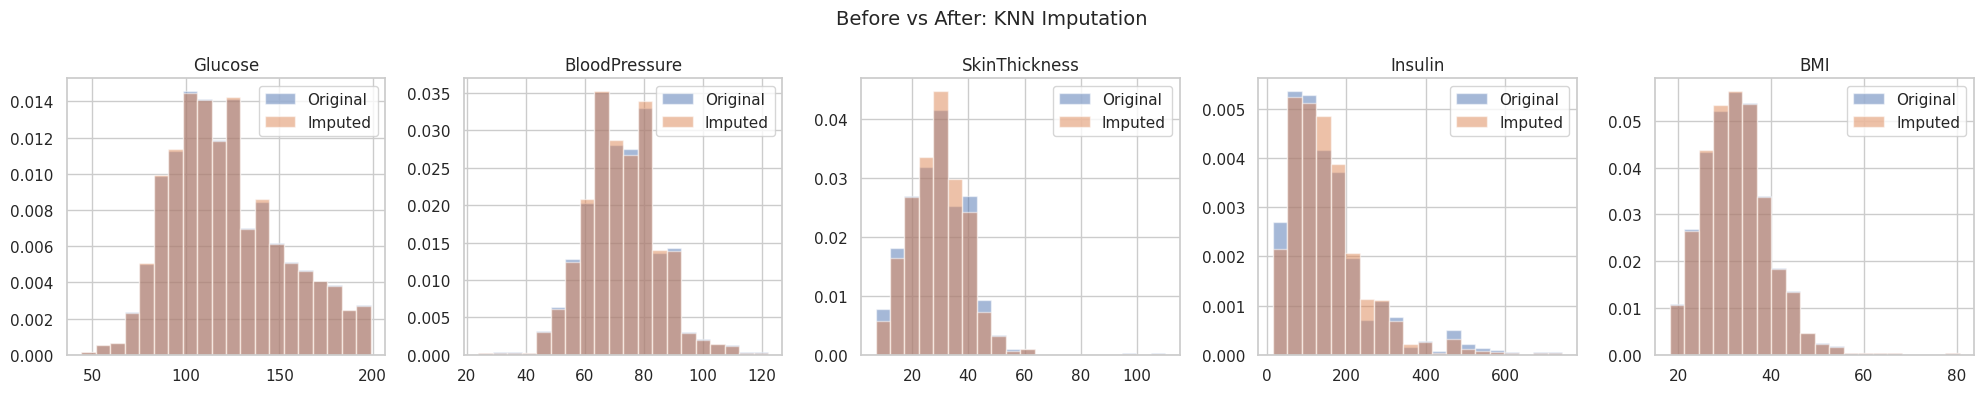

In [156]:
# Visualize distributions before/after for medical cols
cols_to_plot = medical_cols if len(medical_cols) <= 8 else medical_cols[:8]
fig, axes = plt.subplots(1, len(cols_to_plot), figsize=(4*len(cols_to_plot),4))
if len(cols_to_plot) == 1:
    axes = [axes]
for ax, col in zip(axes, cols_to_plot):
    ax.hist(X[col].dropna(), bins=20, alpha=0.5, density=True, label='Original')
    ax.hist(X_imputed[col], bins=20, alpha=0.5, density=True, label='Imputed')
    ax.set_title(col)
    ax.legend()
plt.suptitle('Before vs After: KNN Imputation', fontsize=14)
plt.tight_layout()
plt.savefig(OUTDIR / "imputation_distributions.png", dpi=150, bbox_inches='tight')
plt.show()


In [157]:
# SCALE (RobustScaler)

scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)
joblib.dump(scaler, OUTDIR / "scaler_robust.joblib")


['visualizations/scaler_robust.joblib']

**One class SVM for outliers**

In [158]:
# per-class OneClassSVM

print("Running per-class OneClassSVM outlier detection (balanced approach)...")

non_diabetic_idx = (y == 0)
diabetic_idx = (y == 1)

ocsvm_normal = OneClassSVM(nu=0.03, kernel='rbf', gamma='scale')
ocsvm_diabetic = OneClassSVM(nu=0.05, kernel='rbf', gamma='scale')

# Fit separately
ocsvm_normal.fit(X_scaled.loc[non_diabetic_idx])
ocsvm_diabetic.fit(X_scaled.loc[diabetic_idx])

pred_normal = ocsvm_normal.predict(X_scaled.loc[non_diabetic_idx])
pred_diabetic = ocsvm_diabetic.predict(X_scaled.loc[diabetic_idx])

outliers = np.zeros(len(X_scaled), dtype=bool)
outliers[non_diabetic_idx] = (pred_normal == -1)
outliers[diabetic_idx] = (pred_diabetic == -1)

print(f"Outliers: non-diabetic={outliers[non_diabetic_idx].sum()}, diabetic={outliers[diabetic_idx].sum()}, total={outliers.sum()}")

# Filter outliers
X_no_out = X_scaled.loc[~outliers].reset_index(drop=True)
y_no_out = y.loc[~outliers].reset_index(drop=True)
print("Shape after outlier removal:", X_no_out.shape)


Running per-class OneClassSVM outlier detection (balanced approach)...
Outliers: non-diabetic=92, diabetic=62, total=154
Shape after outlier removal: (1846, 8)


**SMOTE + ENN (for class balance)**

In [159]:
# BALANCING: SMOTE + ENN

print("Balancing with SMOTE+ENN (cautious sampling)...")
smote_enn = SMOTEENN(
    smote=SMOTE(sampling_strategy=0.9, random_state=RND),
    enn=EditedNearestNeighbours(sampling_strategy='majority'),
    random_state=RND
)
X_res_np, y_res_np = smote_enn.fit_resample(X_no_out, y_no_out)
X_res = pd.DataFrame(X_res_np, columns=X_no_out.columns)
y_res = pd.Series(y_res_np)
joblib.dump(smote_enn, OUTDIR / "smote_enn.joblib")

print("After balancing:", np.bincount(y_res.astype(int)))
print("Balanced shape:", X_res.shape)


Balancing with SMOTE+ENN (cautious sampling)...
After balancing: [ 970 1101]
Balanced shape: (2071, 8)


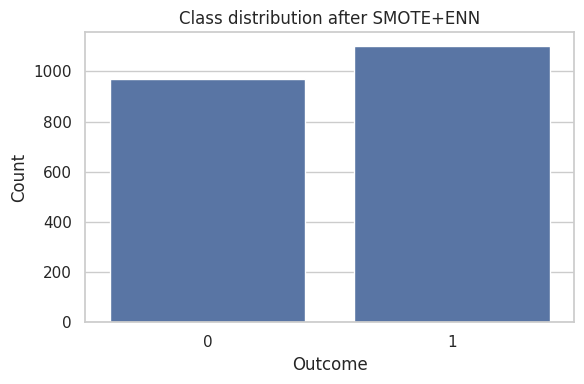

In [160]:
# Quick class distribution plot
plt.figure(figsize=(6,4))
sns.countplot(x=y_res)
plt.title("Class distribution after SMOTE+ENN")
plt.xlabel("Outcome")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(OUTDIR / "balanced_class_distribution.png", dpi=150, bbox_inches='tight')
plt.show()


**Train/Test Split**

In [161]:
# TRAIN/TEST SPLIT

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_res, y_res, test_size=TEST_SIZE, stratify=y_res, random_state=RND
)

print("Train+Val shape:", X_trainval.shape)
print("Test shape:", X_test.shape)


Train+Val shape: (1656, 8)
Test shape: (415, 8)


**Feature Importance Check using Random Forest**

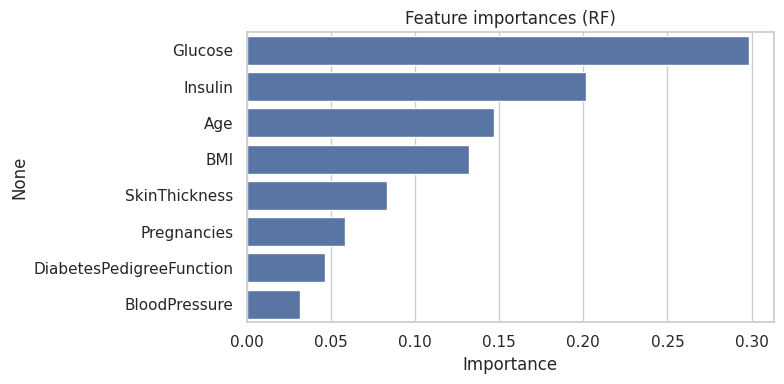

Top features:


,0
Glucose,0.298432
Insulin,0.201811
Age,0.147235
BMI,0.132365
SkinThickness,0.083555
Pregnancies,0.058238
DiabetesPedigreeFunction,0.046618
BloodPressure,0.031745


In [162]:
# FEATURE IMPORTANCE

rf_tmp = RandomForestClassifier(n_estimators=150, max_depth=5, min_samples_split=10, random_state=RND, n_jobs=N_JOBS)
rf_tmp.fit(X_trainval, y_trainval)

estimator = rf_tmp.estimators_[0]
feat_imp = pd.Series(rf_tmp.feature_importances_, index=X_res.columns).sort_values(ascending=False)

plt.figure(figsize=(8, max(4, 0.35*len(feat_imp))))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Feature importances (RF)")
plt.xlabel("Importance")
plt.tight_layout()
plt.savefig(OUTDIR / "feat_importances.png", dpi=150, bbox_inches='tight')
plt.show()

print("Top features:")
display(feat_imp.head(8))


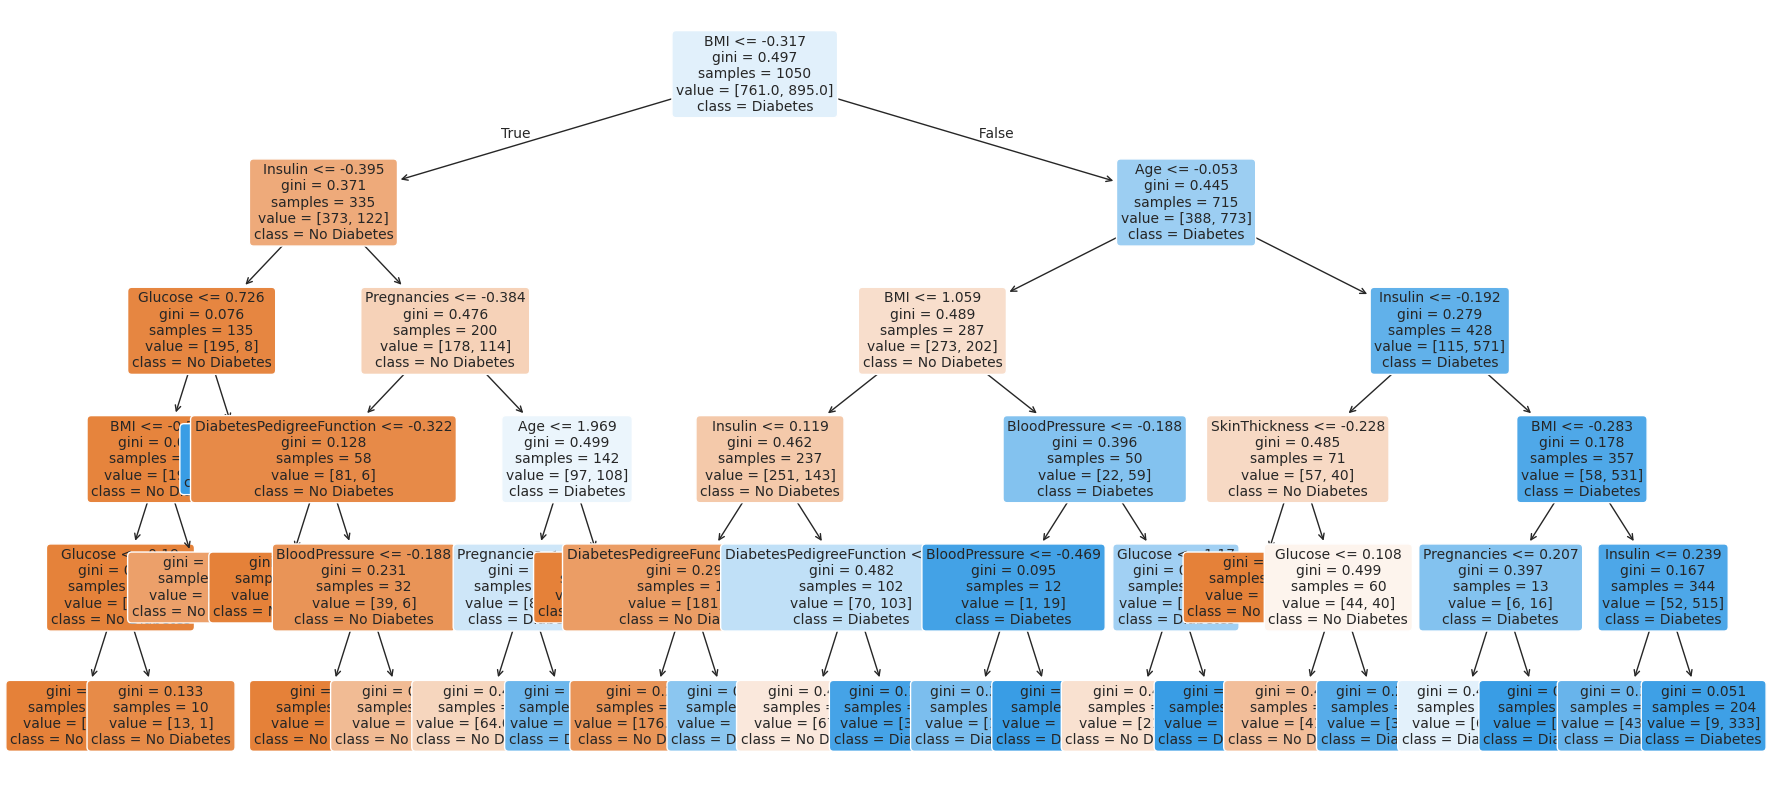

In [163]:
# tree

plt.figure(figsize=(22,10))
tree.plot_tree(
    estimator,
    feature_names=list(X.columns),
    class_names=["No Diabetes", "Diabetes"],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.show()

**HYPERPARAMETER TUNING**

In [164]:

# HYPERPARAMETER TUNING (RandomizedSearchCV)

cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RND)

# KNN tuning
knn = KNeighborsClassifier()
knn_param = {

    'n_neighbors': [5, 7, 9, 11, 13],
    'weights': ['distance', 'uniform'],
    'metric': ['euclidean', 'manhattan', 'minkowski']

}
rs_knn = RandomizedSearchCV(knn, knn_param, n_iter=8, cv=cv, scoring='f1', random_state=RND, n_jobs=N_JOBS)
rs_knn.fit(X_trainval, y_trainval)
best_knn = rs_knn.best_estimator_
print("KNN best f1:", rs_knn.best_score_)

# SVM tuning
svm = SVC(probability=True, random_state=RND)
svm_param = {
    'C': [0.1, 0.5, 1.0, 2.0, 5.0],
    'kernel': ['rbf','linear'],
    'gamma': ['scale','auto', 0.01,0.1],
    'class_weight': [None, 'balanced']
}
rs_svm = RandomizedSearchCV(svm, svm_param, n_iter=10, cv=cv, scoring='f1', random_state=RND, n_jobs=N_JOBS)
rs_svm.fit(X_trainval, y_trainval)
best_svm = rs_svm.best_estimator_
print("SVM best f1:", rs_svm.best_score_)

# XGBoost tuning
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RND, n_jobs=N_JOBS, verbosity=0,)
xgb_param = {
    'n_estimators': [150,200,250,300],
    'max_depth': [3,4,5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7,0.8,0.6],
    'colsample_bytree': [0.6,0.7,0.8],
    'reg_lambda': [5,10,15,20],
    'reg_alpha': [0,0.1,0.5,1],
    'min_child_weight': [1,3,5]

}
rs_xgb = RandomizedSearchCV(xgb, xgb_param, n_iter=15, cv=cv, scoring='f1', random_state=RND, n_jobs=N_JOBS)
rs_xgb.fit(X_trainval, y_trainval)
best_xgb = rs_xgb.best_estimator_
print("XGB best f1:", rs_xgb.best_score_)

# Save tuned base models
joblib.dump(best_knn, OUTDIR / "best_knn.joblib")
joblib.dump(best_svm, OUTDIR / "best_svm.joblib")
joblib.dump(best_xgb, OUTDIR / "best_xgb.joblib")


KNN best f1: 0.9758957887595336
SVM best f1: 0.8926337747049807
XGB best f1: 0.9591334960003529


['visualizations/best_xgb.joblib']

**STACKING ENSEMBLE**

In [165]:
# STACKING ENSEMBLE

meta = RandomForestClassifier(n_estimators=500, max_depth=6, min_samples_split=5, min_samples_leaf=2, max_features='sqrt',  bootstrap=True,random_state=RND, n_jobs=N_JOBS)

stack = StackingClassifier(
    estimators=[('knn', best_knn), ('svm', best_svm), ('xgb', best_xgb)],
    final_estimator=meta,
    cv=cv,
    passthrough=True,
    n_jobs=N_JOBS
)

# Cross-validation on Train+Val (report fold metrics)
fold_metrics = []
for fold, (tr_idx, val_idx) in enumerate(cv.split(X_trainval, y_trainval), start=1):
    X_tr, X_val = X_trainval.iloc[tr_idx], X_trainval.iloc[val_idx]
    y_tr, y_val = y_trainval.iloc[tr_idx], y_trainval.iloc[val_idx]

    stack.fit(X_tr, y_tr)
    y_val_pred = stack.predict(X_val)
    y_val_proba = stack.predict_proba(X_val)[:,1]

    fold_metrics.append({
        'fold': fold,
        'acc': accuracy_score(y_val, y_val_pred),
        'precision': precision_score(y_val, y_val_pred, zero_division=0),
        'recall': recall_score(y_val, y_val_pred, zero_division=0),
        'f1': f1_score(y_val, y_val_pred, zero_division=0),
        'auc': roc_auc_score(y_val, y_val_proba)
    })

fold_df = pd.DataFrame(fold_metrics).set_index('fold')
display(fold_df.round(3))
print("CV mean metrics:")
display(fold_df.mean().round(4))


,acc,precision,recall,f1,auc
fold,,,,,
1,0.982,0.989,0.977,0.983,0.999
2,0.976,0.972,0.983,0.977,0.995
3,0.994,1.000,0.989,0.994,0.998
4,0.982,0.983,0.983,0.983,0.999
5,0.967,0.956,0.983,0.969,0.989


CV mean metrics:


,0
acc,0.9801
precision,0.9798
recall,0.9830
f1,0.9813
auc,0.9961


In [166]:
# Fit on full train_val and save final stack
stack.fit(X_trainval, y_trainval)
joblib.dump(stack, OUTDIR / "stack_final.joblib")


['visualizations/stack_final.joblib']

**HOLDOUT EVALUATION**

In [167]:
# HOLDOUT EVALUATION

y_test_pred = stack.predict(X_test)
y_test_proba = stack.predict_proba(X_test)[:,1]

test_metrics = {
    'accuracy': accuracy_score(y_test, y_test_pred),
    'precision': precision_score(y_test, y_test_pred, zero_division=0),
    'recall': recall_score(y_test, y_test_pred, zero_division=0),
    'f1': f1_score(y_test, y_test_pred, zero_division=0),
    'auc': roc_auc_score(y_test, y_test_proba)
}
print("Test set performance:")
display(pd.Series(test_metrics).round(4))


Test set performance:


,0
accuracy,0.9904
precision,1.0000
recall,0.9819
f1,0.9909
auc,0.9997


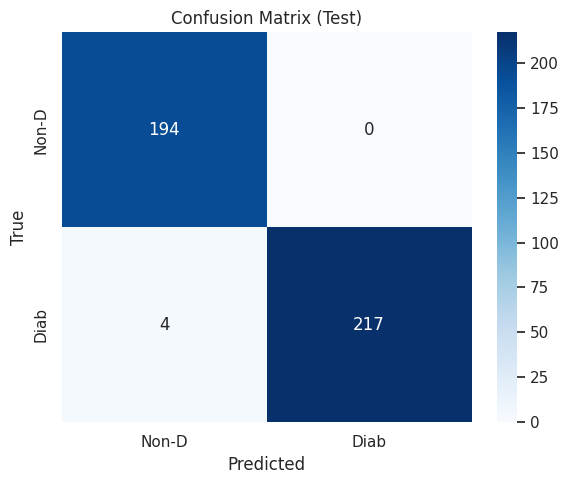

In [168]:
# Confusion matrix + save
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-D', 'Diab'], yticklabels=['Non-D', 'Diab'])
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig(OUTDIR / "cm_test.png", dpi=150, bbox_inches='tight')
plt.show()


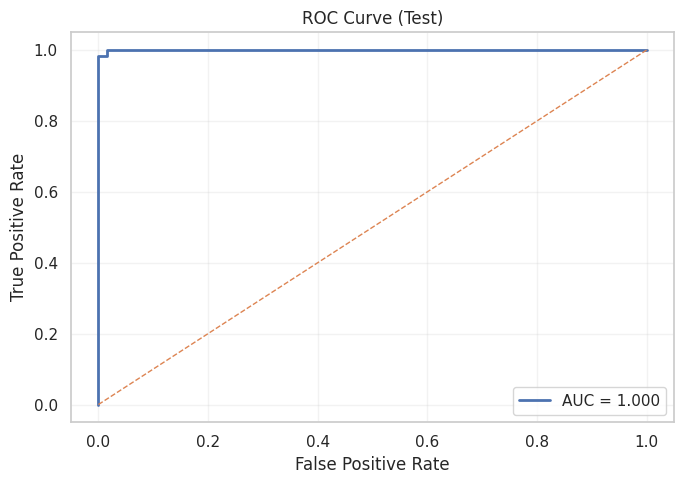

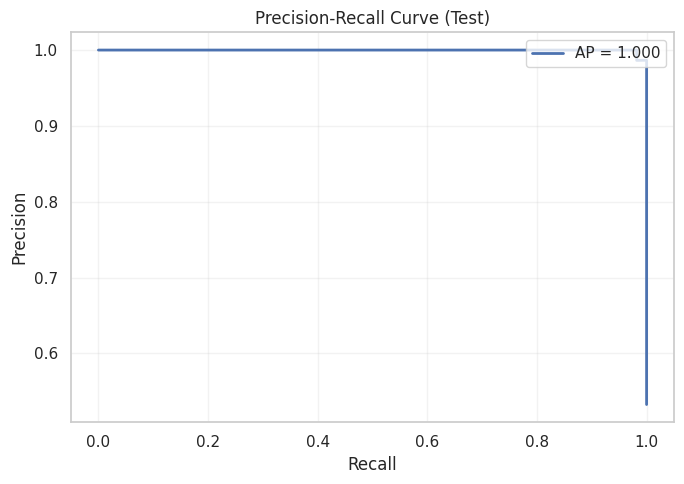

In [169]:
# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1], linestyle='--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test)")
plt.legend(loc="lower right")
plt.grid(alpha=0.25)
plt.tight_layout()
plt.savefig(OUTDIR / "roc_test.png", dpi=150, bbox_inches='tight')
plt.show()

# Precision-Recall curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_test_proba)
ap = average_precision_score(y_test, y_test_proba)
plt.figure(figsize=(7,5))
plt.plot(recall_vals, precision_vals, lw=2, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Test)")
plt.legend(loc="upper right")
plt.grid(alpha=0.25)
plt.tight_layout()
plt.savefig(OUTDIR / "pr_test.png", dpi=150, bbox_inches='tight')
plt.show()


**Learning Rate**

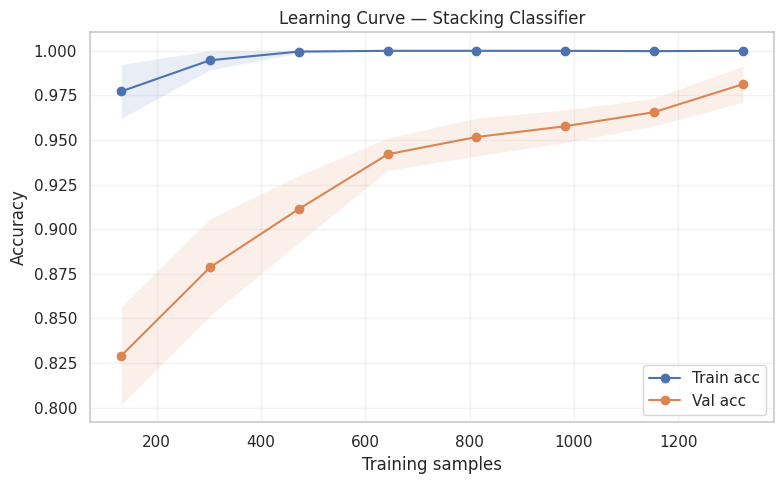

In [170]:
# LEARNING CURVE

train_sizes, train_scores, val_scores = learning_curve(
    stack, X_trainval, y_trainval, cv=cv, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 8), n_jobs=N_JOBS
)
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

plt.figure(figsize=(8,5))
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.12)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.12)
plt.plot(train_sizes, train_mean, 'o-', label='Train acc')
plt.plot(train_sizes, val_mean, 'o-', label='Val acc')
plt.xlabel("Training samples")
plt.ylabel("Accuracy")
plt.title("Learning Curve — Stacking Classifier")
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.savefig(OUTDIR / "learning_curve.png", dpi=150, bbox_inches='tight')
plt.show()


**Gaps / Diagnosis**

In [171]:
# DIAGNOSIS (Gaps & short suggestion)

train_pred_full = stack.predict(X_trainval)
train_acc = accuracy_score(y_trainval, train_pred_full)
train_f1 = f1_score(y_trainval, train_pred_full)

val_acc_mean = fold_df['acc'].mean()
val_f1_mean = fold_df['f1'].mean()

train_val_gap = train_acc - val_acc_mean
val_test_gap = val_acc_mean - test_metrics['accuracy']
train_test_gap = train_acc - test_metrics['accuracy']

diag = dict(
    train_acc=train_acc, train_f1=train_f1,
    val_acc_mean=val_acc_mean, val_f1_mean=val_f1_mean,
    test_acc=test_metrics['accuracy'], test_f1=test_metrics['f1'],
    train_val_gap=train_val_gap, val_test_gap=val_test_gap, train_test_gap=train_test_gap
)
display(pd.Series(diag).round(4))

# Simple diagnosis rules
if train_val_gap > 0.10 and train_acc > 0.95:
    diagnosis = "SEVERE OVERFITTING"
    suggestion = "Increase regularization, reduce complexity, or gather more data."
elif train_val_gap > 0.07 and train_acc > 0.92:
    diagnosis = "MODERATE OVERFITTING"
    suggestion = "Small increase in regularization or more aggressive pruning."
elif train_acc < 0.80 and val_acc_mean < 0.80:
    diagnosis = "UNDERFITTING"
    suggestion = "Increase model capacity or add informative features."
elif abs(val_test_gap) < 0.03 and abs(train_test_gap) < 0.05:
    diagnosis = "WELL-GENERALIZED"
    suggestion = "Good generalization — consider deployment and monitoring."
else:
    diagnosis = "ACCEPTABLE PERFORMANCE"
    suggestion = "Monitor incoming data and retrain periodically."

print("Diagnosis:", diagnosis)
print("Suggestion:", suggestion)


,0
train_acc,1.0000
train_f1,1.0000
val_acc_mean,0.9801
val_f1_mean,0.9813
test_acc,0.9904
test_f1,0.9909
train_val_gap,0.0199
val_test_gap,-0.0103
train_test_gap,0.0096


Diagnosis: WELL-GENERALIZED
Suggestion: Good generalization — consider deployment and monitoring.


**XAI: SHAP**

Running SHAP (global + beeswarm).


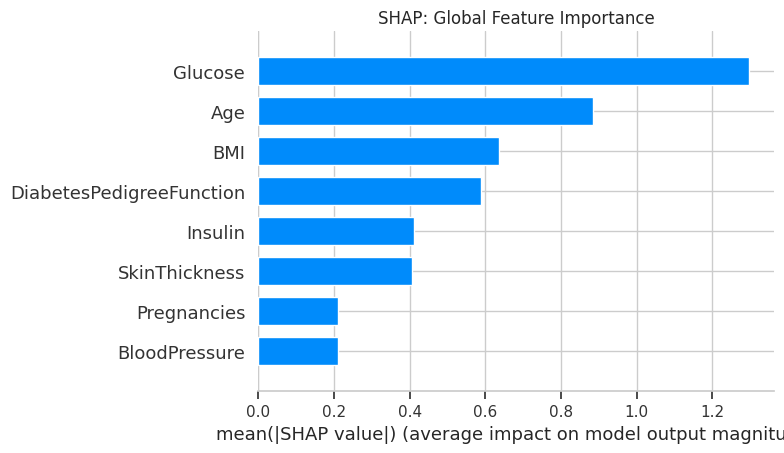

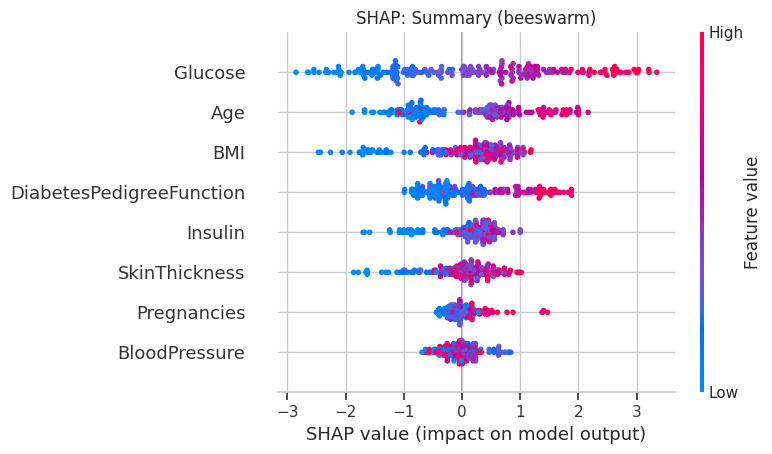

In [172]:
# XAI: SHAP (global + beeswarm) and LIME per-sample explanations

# SHAP
print("Running SHAP (global + beeswarm).")
explainer_xgb = shap.TreeExplainer(best_xgb)
sample_size = min(200, len(X_trainval))
X_shap_sample = X_trainval.sample(n=sample_size, random_state=RND)
# Depending on shap version, call may return different shapes
try:
    shap_values = explainer_xgb.shap_values(X_shap_sample)
except Exception:
    shap_values = explainer_xgb(X_shap_sample).values

# Global importance (bar)
plt.figure(figsize=(8,6))
shap.summary_plot(shap_values, X_shap_sample, plot_type="bar", show=False)
plt.title("SHAP: Global Feature Importance")
plt.tight_layout()
plt.savefig(OUTDIR / "shap_global_importance.png", dpi=150, bbox_inches='tight')
plt.show()

# Beeswarm summary
plt.figure(figsize=(10,6))
shap.summary_plot(shap_values, X_shap_sample, show=False)
plt.title("SHAP: Summary (beeswarm)")
plt.tight_layout()
plt.savefig(OUTDIR / "shap_summary.png", dpi=150, bbox_inches='tight')
plt.show()


**XAI: LIME**

Running LIME explanations for up to 3 representative test samples.


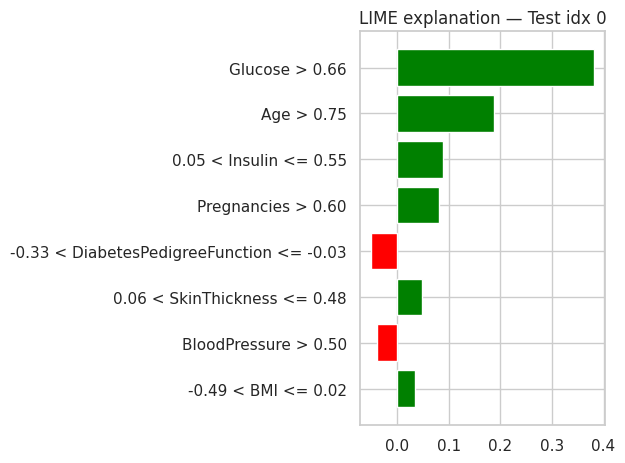

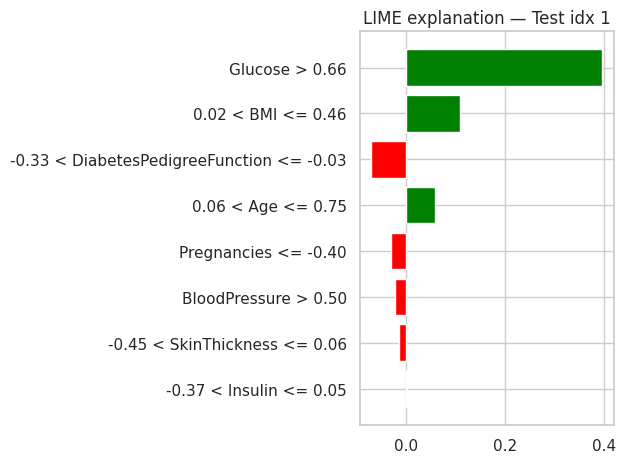

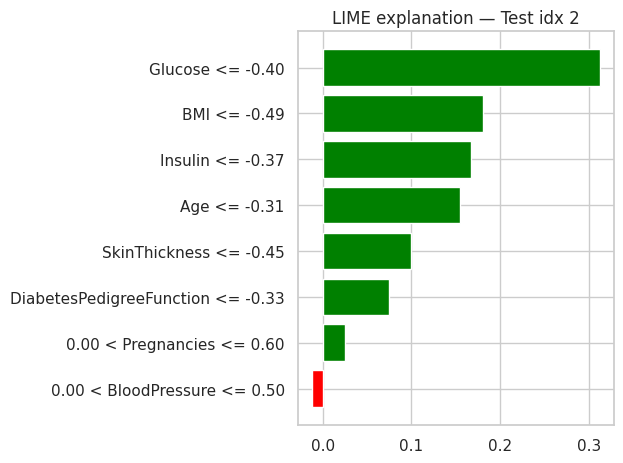

In [173]:
# LIME explanations for selected test samples
print("Running LIME explanations for up to 3 representative test samples.")
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_trainval.values,
    feature_names=X_res.columns.tolist(),
    class_names=['Non-Diabetic', 'Diabetic'],
    discretize_continuous=True,
    random_state=RND
)

# pick: 1 confident correct, 1 incorrect (if any), 1 borderline if available
selected_indices = []
for idx in range(len(X_test)):
    if len(selected_indices) >= 3:
        break
    prob = y_test_proba[idx]
    pred = y_test_pred[idx]
    true = y_test.iloc[idx]
    if pred == true and abs(prob - 0.5) > 0.3:
        selected_indices.append(idx)
    elif pred != true:
        selected_indices.append(idx)
    elif 0.4 < prob < 0.6:
        selected_indices.append(idx)

for i, idx in enumerate(selected_indices, 1):
    exp = lime_explainer.explain_instance(X_test.iloc[idx].values, stack.predict_proba, num_features=min(8, X_test.shape[1]), top_labels=1)
    # Save HTML and PNG
    html_path = OUTDIR / f"lime_explanation_test_{i}.html"
    with open(html_path, "w") as f:
        f.write(exp.as_html())
    fig = exp.as_pyplot_figure(label=exp.available_labels()[0])
    plt.title(f"LIME explanation — Test idx {idx}")
    plt.tight_layout()
    png_path = OUTDIR / f"lime_test_{i}.png"
    plt.savefig(png_path, dpi=150, bbox_inches='tight')
    plt.show()


**FINAL SUMMARY **

In [174]:
# FINAL SUMMARY & SAVE PREDICTIONS

summary_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC',
               'Train-Val Gap', 'Val-Test Gap', 'Train-Test Gap'],
    'Value': [test_metrics['accuracy'], test_metrics['precision'], test_metrics['recall'], test_metrics['f1'], test_metrics['auc'],
              train_val_gap, val_test_gap, train_test_gap],
    'Stage': ['Test','Test','Test','Test','Test','Comparison','Comparison','Comparison']
})
print("Performance summary (saved):")
display(summary_df.round(4))

summary_df.to_csv(OUTDIR / "model_performance_summary.csv", index=False)

# Save test predictions
predictions_df = pd.DataFrame({
    'True_Label': y_test.values,
    'Predicted_Label': y_test_pred,
    'Probability_Diabetic': y_test_proba
})
predictions_df.to_csv(OUTDIR / "test_predictions.csv", index=False)

# Save artifacts list
artifacts = {
    "imputer": "imputer_knn.joblib",
    "scaler": "scaler_robust.joblib",
    "smote_enn": "smote_enn.joblib",
    "best_knn": "best_knn.joblib",
    "best_svm": "best_svm.joblib",
    "best_xgb": "best_xgb.joblib",
    "stack_final": "stack_final.joblib",
    "visualizations_folder": str(OUTDIR)
}
print("Saved artifacts:")
display(artifacts)


Performance summary (saved):


,Metric,Value,Stage
0,Accuracy,0.9904,Test
1,Precision,1.0000,Test
2,Recall,0.9819,Test
3,F1-Score,0.9909,Test
4,AUC-ROC,0.9997,Test
5,Train-Val Gap,0.0199,Comparison
6,Val-Test Gap,-0.0103,Comparison
7,Train-Test Gap,0.0096,Comparison


Saved artifacts:


{'imputer': 'imputer_knn.joblib',
 'scaler': 'scaler_robust.joblib',
 'smote_enn': 'smote_enn.joblib',
 'best_knn': 'best_knn.joblib',
 'best_svm': 'best_svm.joblib',
 'best_xgb': 'best_xgb.joblib',
 'stack_final': 'stack_final.joblib',
 'visualizations_folder': 'visualizations'}

# End of Notebook
All core results & visuals saved to `visualizations/`.  
Files of interest:
- `model_performance_summary.csv` — final metrics
- `test_predictions.csv` — predictions & probabilities
- PNGs: confusion matrix, ROC, PR, learning curve, SHAP plots, feature importances
- LIME HTML explanations per selected test sample
- joblib files for pipeline artifacts and models
